In [1]:
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import subprocess

# --- Phase 1: Lightweight packages ---
phase1 = [
    "scikit-learn",
    "torch",
    "matplotlib",
    "seaborn",
    "ultralytics",
    "pandas"
]

# --- Function to install packages with live output ---
def install_packages(package_list, phase_name):
    logs = []
    display(HTML(f"<h3>🚀 Starting {phase_name}</h3>"))
    for pkg in tqdm(package_list, desc=f"{phase_name}", unit="pkg"):
        display(HTML(f"<b>Installing:</b> {pkg}"))
        process = subprocess.Popen(
            ["pip", "install", "--no-cache-dir", "--upgrade", pkg],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )
        output = ""
        for line in process.stdout:
            output += line
        process.wait()
        logs.append(f"📦 {pkg}\n{output}")
    return logs

# --- Run both phases ---
logs_phase1 = install_packages(phase1, "Phase 1: Core Packages")

# --- Display combined logs ---
all_logs = logs_phase1
scrollable_logs = (
    "<pre style='max-height: 400px; overflow-y: scroll; border: 1px solid #ccc; padding: 10px;'>"
    + "\n\n".join(all_logs) + "</pre>"
)
display(HTML(scrollable_logs))

Phase 1: Core Packages:   0%|          | 0/6 [00:00<?, ?pkg/s]

In [2]:
!pip install "numpy<2.0" pandas --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.7 which is incompatibl

In [3]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split

BASE_DIR = "/kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0"
IMG_DIR  = os.path.join(BASE_DIR, "Patients_CT")

print("Base:", BASE_DIR)
print("Images:", IMG_DIR)
print("Patient folders:", os.listdir(IMG_DIR)[:10])

Base: /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0
Images: /kaggle/input/computed-tomography-ct-images/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT
Patient folders: ['057', '086', '121', '061', '053', '051', '095', '078', '056', '120']


In [4]:
# Loading the csv data
hem_data = pd.read_csv(os.path.join(BASE_DIR, "hemorrhage_diagnosis.csv"))
hem_data.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [5]:
hem_data.columns

Index(['PatientNumber', 'SliceNumber', 'Intraventricular', 'Intraparenchymal',
       'Subarachnoid', 'Epidural', 'Subdural', 'No_Hemorrhage',
       'Fracture_Yes_No'],
      dtype='object')

In [6]:
# Create zero-padded patient folder names
hem_data["PatientFolder"] = hem_data["PatientNumber"].apply(lambda x: f"{int(x):03d}")
hem_data[["PatientNumber", "PatientFolder"]].head()

,PatientNumber,PatientFolder
0,49,049
1,49,049
2,49,049
3,49,049
4,49,049


In [7]:
# 3. Mapping function for BRAIN images (as earlier)
def get_brain_image_path(row):
    folder = row["PatientFolder"]
    slice_num = int(row["SliceNumber"])
    brain_dir = os.path.join(IMG_DIR, folder, "brain")

    candidates = [
        f"{slice_num}.jpg",
        f"{slice_num}.png",
        f"{slice_num}.jpeg",
        f"Slice_{slice_num}.jpg",
        f"Slice_{slice_num}.png"
    ]

    for name in candidates:
        full_path = os.path.join(brain_dir, name)
        if os.path.exists(full_path):
            return full_path
    return None

In [8]:
# Apply brain mapping
hem_data["image_path"] = hem_data.apply(get_brain_image_path, axis=1)
mapped_df = hem_data[hem_data["image_path"].notnull()].reset_index(drop=True)

mapped_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path
0,49,1,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
1,49,2,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
2,49,3,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
3,49,4,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...
4,49,5,0,0,0,0,0,1,0,049,/kaggle/input/computed-tomography-ct-images/co...


## **Create the Binary Hemorrhage Label**

In [9]:
# Define the hemorrhage subtype columns
hemo_cols = [
    "Intraventricular", "Intraparenchymal",
    "Subarachnoid", "Epidural",
    "Subdural", "Fracture_Yes_No"
]

In [10]:
# Create binary label
mapped_df["Binary_Hemorrhage"] = (mapped_df[hemo_cols].sum(axis=1) > 0).astype(int)

In [11]:
# Check counts
mapped_df["Binary_Hemorrhage"].value_counts()

Binary_Hemorrhage
0    2109
1     392
Name: count, dtype: int64

In [12]:
# Create brain & bone image paths
def get_brain_path(row):
    folder = row["PatientFolder"]
    slice_num = int(row["SliceNumber"])
    dir_path = os.path.join(IMG_DIR, folder, "brain")

    candidates = [
        f"{slice_num}.jpg", f"{slice_num}.png",
        f"Slice_{slice_num}.jpg", f"Slice_{slice_num}.png"
    ]
    for name in candidates:
        if os.path.exists(os.path.join(dir_path, name)):
            return os.path.join(dir_path, name)
    return None


def get_bone_path(row):
    folder = row["PatientFolder"]
    slice_num = int(row["SliceNumber"])
    dir_path = os.path.join(IMG_DIR, folder, "bone")

    candidates = [
        f"{slice_num}.jpg", f"{slice_num}.png",
        f"Slice_{slice_num}.jpg", f"Slice_{slice_num}.png"
    ]
    for name in candidates:
        if os.path.exists(os.path.join(dir_path, name)):
            return os.path.join(dir_path, name)
    return None

In [13]:
# Apply mappings
mapped_df["brain_path"] = mapped_df.apply(get_brain_path, axis=1)
mapped_df["bone_path"]  = mapped_df.apply(get_bone_path, axis=1)

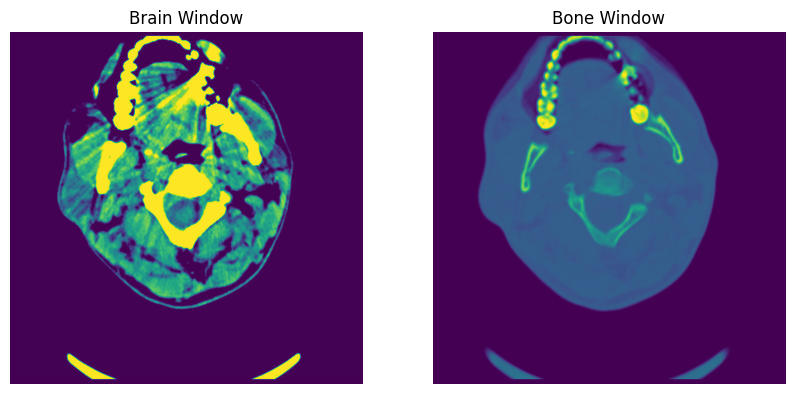

In [14]:
# Visual validation
import matplotlib.pyplot as plt
from PIL import Image

def show_brain_bone(idx):
    row = mapped_df.iloc[idx]
    brain = Image.open(row["brain_path"])
    bone  = Image.open(row["bone_path"])

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(brain)
    plt.title("Brain Window")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(bone)
    plt.title("Bone Window")
    plt.axis("off")
    plt.show()

show_brain_bone(0)

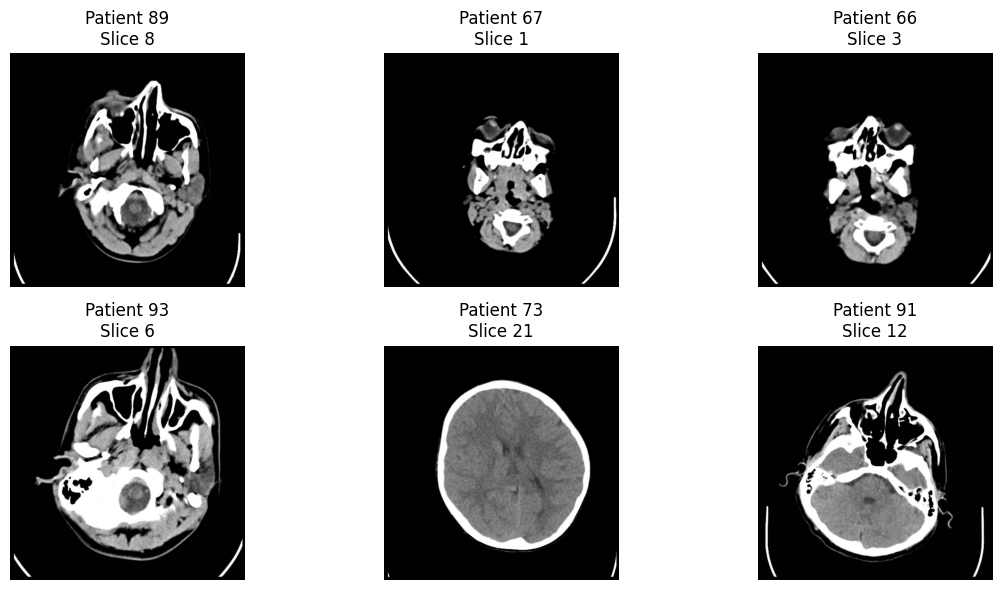

In [15]:
# SHOW RANDOM ORIGINAL BRAIN CT IMAGES
import matplotlib.pyplot as plt
import random

def show_random_images(df, n=6):
    plt.figure(figsize=(12, 6))

    for i in range(n):
        idx = random.randint(0, len(df)-1)
        row = df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")

        plt.subplot(2, n//2, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Patient {row['PatientNumber']}\nSlice {row['SliceNumber']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(mapped_df, n=6)

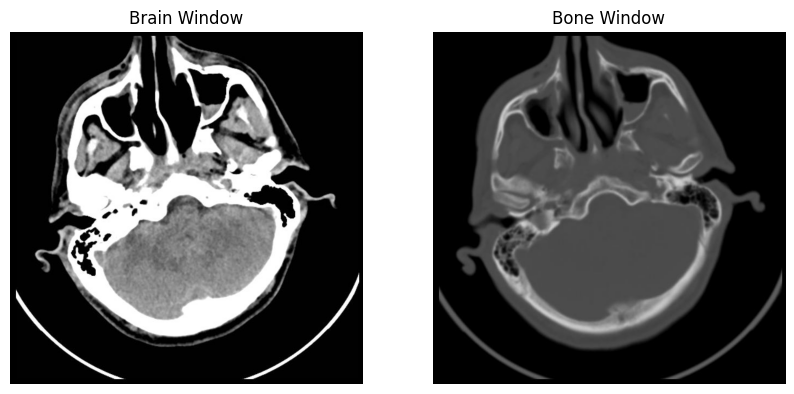

In [16]:
# Show brain vs bone window
def show_brain_bone(patient_folder, slice_num):
    brain_path = os.path.join(IMG_DIR, patient_folder, "brain", f"{slice_num}.jpg")
    bone_path  = os.path.join(IMG_DIR, patient_folder, "bone",  f"{slice_num}.jpg")

    brain_img = Image.open(brain_path).convert("RGB")
    bone_img  = Image.open(bone_path).convert("RGB")

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(brain_img)
    plt.title("Brain Window")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(bone_img)
    plt.title("Bone Window")
    plt.axis("off")

    plt.show()

# Example:
show_brain_bone("049", 10)

## **Patient-wise Split + Oversampling for Brain+Bone Model**

In [17]:
# Removing null values
mapped_df = mapped_df.dropna(subset=["brain_path", "bone_path"]).reset_index(drop=True)

In [18]:
print("Missing brain:", mapped_df["brain_path"].isnull().sum())
print("Missing bone :", mapped_df["bone_path"].isnull().sum())

Missing brain: 0
Missing bone : 0


In [19]:
# Patient-wise Split
patients = mapped_df["PatientFolder"].unique()

from sklearn.model_selection import train_test_split

train_patients, temp_patients = train_test_split(
    patients, test_size=0.20, random_state=42
)

val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

train_df = mapped_df[mapped_df["PatientFolder"].isin(train_patients)].reset_index(drop=True)
val_df   = mapped_df[mapped_df["PatientFolder"].isin(val_patients)].reset_index(drop=True)
test_df  = mapped_df[mapped_df["PatientFolder"].isin(test_patients)].reset_index(drop=True)

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))

Train: 1986
Val  : 234
Test : 280


In [20]:
# Check binary class balance
print("Train class counts:")
print(train_df["Binary_Hemorrhage"].value_counts())

Train class counts:
Binary_Hemorrhage
0    1701
1     285
Name: count, dtype: int64


In [21]:
# Transforms
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [22]:
# Dataset class for Brain + Bone
class BrainBoneDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        brain = Image.open(row["brain_path"]).convert("RGB")
        bone  = Image.open(row["bone_path"]).convert("RGB")

        if self.transform:
            brain = self.transform(brain)
            bone  = self.transform(bone)

        label = torch.tensor(row["Binary_Hemorrhage"], dtype=torch.float32)
        return brain, bone, label

In [23]:
# Dataset created
train_dataset = BrainBoneDataset(train_df, transform=train_transform)
val_dataset   = BrainBoneDataset(val_df,   transform=val_transform)
test_dataset  = BrainBoneDataset(test_df,  transform=val_transform)

In [24]:
# Oversampling
class_counts = train_df["Binary_Hemorrhage"].value_counts()
print(class_counts)

sample_weights = train_df["Binary_Hemorrhage"].apply(
    lambda x: 1.0 / class_counts[x]
).values

Binary_Hemorrhage
0    1701
1     285
Name: count, dtype: int64


In [25]:
# Create sampler
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

In [26]:
# DataLoaders with Oversampling
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [27]:
# Validate oversampling works
for i in range(3):
    brain, bone, labels = next(iter(train_loader))
    print(f"Batch {i+1} hemorrhage count:", labels.sum().item(), "/", len(labels))

Batch 1 hemorrhage count: 7.0 / 16
Batch 2 hemorrhage count: 8.0 / 16
Batch 3 hemorrhage count: 8.0 / 16


## **Build the Dual-Branch EfficientNet (Brain + Bone Fusion Model)**

              Brain Image ────────────┐
                                      │
          EfficientNet-B0 (brain) ────┤── concatenate ── FC ── output (1)
                                      │
              Bone Image ─────────────┘
          EfficientNet-B0 (bone)

In [28]:
# Model Definition
class DualBranchEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Brain branch
        self.brain_net = models.efficientnet_b0(weights="DEFAULT")
        in_features = self.brain_net.classifier[1].in_features
        self.brain_net.classifier[1] = nn.Identity()   # remove final FC

        # Bone branch
        self.bone_net = models.efficientnet_b0(weights="DEFAULT")
        self.bone_net.classifier[1] = nn.Identity()

        # Fusion head
        self.fc = nn.Linear(in_features * 2, 1)  # binary output

    def forward(self, brain_img, bone_img):
        brain_feat = self.brain_net(brain_img)  # [B, 1280]
        bone_feat  = self.bone_net(bone_img)    # [B, 1280]

        fused = torch.cat((brain_feat, bone_feat), dim=1)  # [B, 2560]

        output = self.fc(fused)  # [B, 1]
        return output

In [29]:
# Initialize Model, Loss, Optimizer
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return loss.mean()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualBranchEfficientNet().to(device)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s] 


In [31]:
# Test the model with one batch
brain, bone, labels = next(iter(train_loader))
brain, bone, labels = brain.to(device), bone.to(device), labels.to(device)

with torch.no_grad():
    out = model(brain, bone)
    print("Output shape:", out.shape)

Output shape: torch.Size([16, 1])


## **Train the Dual-Branch Model (full training loop)**

In [32]:
# Training Function
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for brain, bone, labels in loader:
        brain = brain.to(device)
        bone = bone.to(device)
        labels = labels.to(device).unsqueeze(1)  # [B] -> [B,1]

        optimizer.zero_grad()

        outputs = model(brain, bone)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * brain.size(0)

    return running_loss / len(loader.dataset)

In [33]:
# Validation Function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for brain, bone, labels in loader:
            brain = brain.to(device)
            bone = bone.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(brain, bone)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * brain.size(0)

    return running_loss / len(loader.dataset)

In [34]:
# Training Loop With Model Saving
EPOCHS = 10   # you can increase to 15–20 later
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss  : {val_loss:.4f}")

    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_dual_model.pth")
        print("  -> Saved best model")

Epoch 1/10
  Train Loss: 0.0238
  Val Loss  : 0.0168
  -> Saved best model
Epoch 2/10
  Train Loss: 0.0135
  Val Loss  : 0.0153
  -> Saved best model
Epoch 3/10
  Train Loss: 0.0126
  Val Loss  : 0.0130
  -> Saved best model
Epoch 4/10
  Train Loss: 0.0093
  Val Loss  : 0.0221
Epoch 5/10
  Train Loss: 0.0078
  Val Loss  : 0.0230
Epoch 6/10
  Train Loss: 0.0072
  Val Loss  : 0.0194
Epoch 7/10
  Train Loss: 0.0067
  Val Loss  : 0.0252
Epoch 8/10
  Train Loss: 0.0056
  Val Loss  : 0.0180
Epoch 9/10
  Train Loss: 0.0039
  Val Loss  : 0.0187
Epoch 10/10
  Train Loss: 0.0032
  Val Loss  : 0.0243


In [35]:
# Verify the model saved
os.path.exists("best_dual_model.pth")

True

## **Evaluation of the Dual-Branch Hemorrhage Detector**

In [36]:
# Load the Best Saved Model
best_model = DualBranchEfficientNet().to(device)
best_model.load_state_dict(torch.load("best_dual_model.pth"))
best_model.eval()

DualBranchEfficientNet(
  (brain_net): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

In [37]:
mapped_df[mapped_df["bone_path"].isnull()].head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path,Binary_Hemorrhage,brain_path,bone_path


In [38]:
mapped_df[mapped_df["brain_path"].isnull()].head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,PatientFolder,image_path,Binary_Hemorrhage,brain_path,bone_path


In [39]:
# Make Predictions on Test Set
import torch.nn.functional as F

all_logits = []
all_probs  = []
all_labels = []

with torch.no_grad():
    for brain, bone, labels in test_loader:
        brain = brain.to(device)
        bone = bone.to(device)
        
        logits = best_model(brain, bone)
        probs = torch.sigmoid(logits)

        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(labels)

# Combine into single tensors
all_logits = torch.cat(all_logits).numpy().flatten()
all_probs  = torch.cat(all_probs).numpy().flatten()
all_labels = torch.cat(all_labels).numpy().flatten()

In [40]:
# Compute Basic Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Default threshold for now
preds_05 = (all_probs > 0.5).astype(int)

acc = accuracy_score(all_labels, preds_05)
prec = precision_score(all_labels, preds_05, zero_division=0)
rec = recall_score(all_labels, preds_05, zero_division=0)
f1  = f1_score(all_labels, preds_05, zero_division=0)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

Accuracy : 0.7535714285714286
Precision: 0.627906976744186
Recall   : 0.5934065934065934
F1 Score : 0.6101694915254238


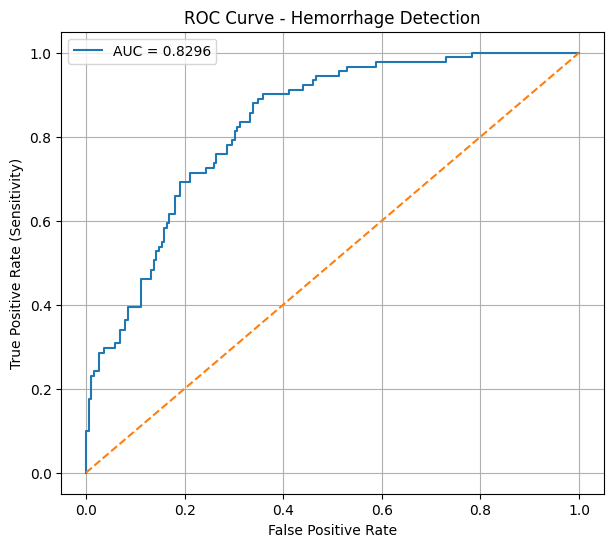

In [41]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Hemorrhage Detection")
plt.legend()
plt.grid()
plt.show()

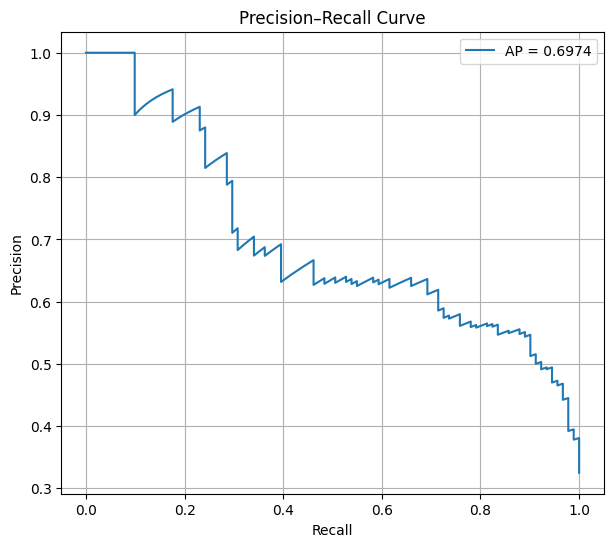

In [42]:
# Precision–Recall Curve and AUC
from sklearn.metrics import precision_recall_curve, average_precision_score

precisions, recalls, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid()
plt.show()

## **Find Optimal Thresholds**

In [43]:
import numpy as np

# F1 threshold
f1_scores = []
for t in thresholds:
    preds = (all_probs > t).astype(int)
    f1_scores.append(f1_score(all_labels, preds, zero_division=0))
best_f1_thresh = thresholds[np.argmax(f1_scores)]

# Youden's J threshold (maximizes sensitivity+specificity)
J = tpr - fpr
best_j_thresh = thresholds[np.argmax(J)]

# ROC min-distance threshold
dist = np.sqrt((1-tpr)**2 + (fpr)**2)
best_roc_thresh = thresholds[np.argmin(dist)]

# PR-F1 threshold using PR curve
f1_pr_scores = (2*precisions*recalls)/(precisions+recalls+1e-8)
best_pr_thresh = pr_thresholds[np.argmax(f1_pr_scores[:-1])]  # last element is nan

In [44]:
print("=== Optimal Thresholds ===")
print(f"Best F1 Threshold          : {best_f1_thresh:.3f}")
print(f"Best Youden J Threshold    : {best_j_thresh:.3f}")
print(f"Best ROC Distance Threshold: {best_roc_thresh:.3f}")
print(f"Best PR-F1 Threshold       : {best_pr_thresh:.3f}")

=== Optimal Thresholds ===
Best F1 Threshold          : 0.290
Best Youden J Threshold    : 0.278
Best ROC Distance Threshold: 0.339
Best PR-F1 Threshold       : 0.297


In [46]:
# Evaluating with that threshold
opt_thresh = best_pr_thresh  # or best_f1_thresh

preds_opt = (all_probs > opt_thresh).astype(int)

acc = accuracy_score(all_labels, preds_opt)
prec = precision_score(all_labels, preds_opt)
rec = recall_score(all_labels, preds_opt)
f1  = f1_score(all_labels, preds_opt)

print("Optimized Accuracy :", acc)
print("Optimized Precision:", prec)
print("Optimized Recall   :", rec)
print("Optimized F1       :", f1)

Optimized Accuracy : 0.7285714285714285
Optimized Precision: 0.5524475524475524
Optimized Recall   : 0.8681318681318682
Optimized F1       : 0.6752136752136753


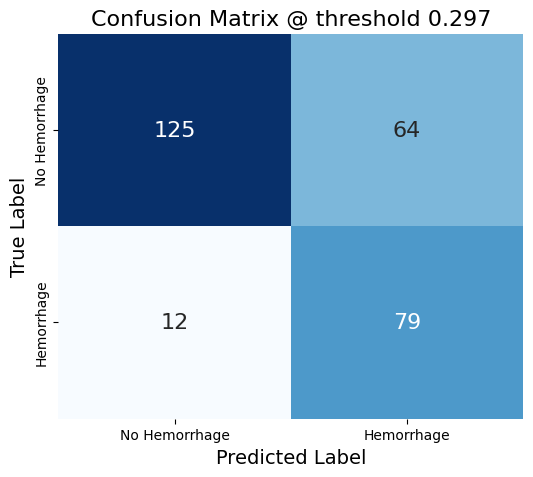

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, preds_opt)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    annot_kws={"size": 16}
)

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title(f"Confusion Matrix @ threshold {opt_thresh:.3f}", fontsize=16)
plt.xticks([0.5,1.5], ["No Hemorrhage", "Hemorrhage"])
plt.yticks([0.5,1.5], ["No Hemorrhage", "Hemorrhage"])
plt.show()